1º Hacemos una media movil (suavizado de la señal) para eliminar un poco el ruido. (Luego calculando el ruido de la señal, se volverá a añadir a la predicción un ruido de similares características.)  

2º Normalizamos entre MinMax para que este la predicción entre 0 y 1.    

3º Agrupamos jerarquicamente y hacemos clusters sobre los que hacer modelos.   

4º Hacemos un modelo LSTM para cada cluster. Este modelo recibe una ventana temporal y predice otra futura (en principio la queremos de 7días).

5º Modelo que también reciba de input señales de temperatura etc...

## Librerias y funciones  

In [3]:
import numpy as np 
import os 
import tensorflow as tf
import sklearn 
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#clustering
from scipy.cluster.hierarchy import complete,single, fcluster,dendrogram
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances
import datetime
import seaborn as sns




#esta funcion coge series como input y las secciona, dando n puntos iniciales (feature) y los m siguientes (labels)

def window(data_big,size_input,size_output=None,data_aux=None):
  if size_output is not None:
    #esto para implementar que se devuelvan ventanas mas grandes
    features=[]
    labels=[]
    #if data_aux is not None:
      #data_aux=data_aux.T

    for i in range(0,data_big.shape[0]):
      data=data_big[i]
      for j in range(data_big.shape[1] - size_input -size_output):
        if data_aux is not None:
          data_aux_slice=data_aux[j:(j+size_input),:]
          features.append(np.hstack([data[j:(j+size_input)][...,np.newaxis],data_aux_slice]))
        else:
          features.append(data[j:(j+size_input)])
        labels.append(data[(j+size_input):(j+size_input+size_output)])
  else:
    features=[]
    labels=[]
    for i in range(0,data_big.shape[0]):
      data=data_big[i]
      for j in range(data_big.shape[1] - size_input -1):
        if data_aux is not None:
          data_aux_slice=data_aux[j:(j+size_input),:]
          features.append(np.hstack([data[j:(j+size_input)][...,np.newaxis],data_aux_slice]))
        else:
          features.append(data[j:(j+size_input)])
        labels.append(data[j+size_input+1])
  return np.array(features),np.array(labels)  



#funcion que coge una serie temporal, un modelo y va predicciendo todo lo que puede 
#si toma inputs de 20 y devuelve 7, va prediciendo asi la serie temporal (de 7 en en 7 conociendo los 20 anteriores)
def pred_model2(model,ts,window):
  input_size=model.input_shape[1]
  leng=ts.shape[0]
  preds=[]
  for i in range(input_size,leng-window,window):
    preds.append(model.predict(ts[(i-input_size):i][np.newaxis,...])[0])
  return np.array(preds)

### Carga y tratado de los datos

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
datos=pd.read_csv("/content/drive/MyDrive/MasterCD/hackatlon/datos/consumo_aggbyday_filledzeros_samelength.csv" ,sep=",")
lectura=datos.iloc[:,1:].fillna(0,inplace=False).to_numpy().T

#vamos a suavizar todo y a escalarlo
data_filtered=ndimage.gaussian_filter(lectura,[0,3],0)
scaler=MinMaxScaler()
data_pre=scaler.fit_transform(data_filtered.T).T

### Clustering jerarquico

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:360: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


(196, 365)
(1062, 365)
(782, 365)
(707, 365)


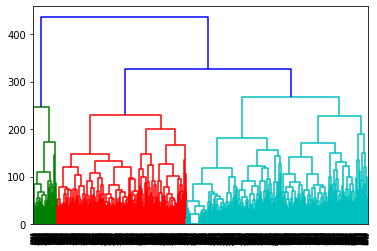

In [7]:
d=pairwise_distances(data_pre)
a=complete(d)
dendrogram(a);
ind=fcluster(a,4,"maxclust")
#sacamos los subgrupos, escogemos solo 4
datos_g=[]
for i in range(1,5):
  datos_g.append(data_pre[ind==i])
  print(datos_g[i-1].shape)



### Enventanamos los datos para crear el set de entrenamiento

Procedemos solo con el subgrupo que mas elementos tiene, pero esto se debería hacer con todos.

In [8]:
feat,labs=window(datos_g[1],20,7)
print(labs.shape,feat.shape)
x_train,x_test,y_train,y_test= train_test_split(feat,labs,test_size=0.2)


(358956, 7) (358956, 20)


### Entrenamos la LSTM

In [9]:
#la creamos
input=tf.keras.layers.Input(shape=[20,1])
x=tf.keras.layers.LSTM(30,return_sequences=True)(input)
x=tf.keras.layers.LSTM(60,return_sequences=False)(x)
x=tf.keras.layers.Dense(50,activation="relu",kernel_regularizer="l2")(x)
x=tf.keras.layers.Dense(7,activation="sigmoid",kernel_regularizer="l2")(x)

model=tf.keras.Model(input,x)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 60)                21840     
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                                 
 dense_1 (Dense)             (None, 7)                 357       
                                                                 
Total params: 29,087
Trainable params: 29,087
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#la entrenamos
model.compile(optimizer="adam",loss="mse")
hist=model.fit(x_train,y_train,epochs=20,batch_size=128,validation_split=0.2)

Epoch 1/20
1795/1795 [==============================] - 86s 45ms/step - loss: 0.0573 - val_loss: 0.0235
Epoch 2/20
1795/1795 [==============================] - 91s 51ms/step - loss: 0.0219 - val_loss: 0.0205
Epoch 3/20
1795/1795 [==============================] - 82s 45ms/step - loss: 0.0201 - val_loss: 0.0196
Epoch 4/20
1795/1795 [==============================] - 90s 50ms/step - loss: 0.0192 - val_loss: 0.0188
Epoch 5/20
1795/1795 [==============================] - 67s 37ms/step - loss: 0.0187 - val_loss: 0.0186
Epoch 6/20
1795/1795 [==============================] - 71s 39ms/step - loss: 0.0183 - val_loss: 0.0180
Epoch 7/20
1431/1795 [======================>.......] - ETA: 15s - loss: 0.0181

In [ ]:
#veamos los resultados
plt.figure(figsize=(13,9))
for i,m in enumerate([23,56,76,43,12,65]):
  plt.subplot(2,3,i+1)
  a=pred_model2(model,datos_g[1][m],7)
  a.shape
  a=a.flatten()
  plt.plot(datos_g[1][m][20:])
  plt.plot(a,"--")

In [ ]:
#hay un problema y es que los datos estan normalizados, entonces, tenemos que devolverlos a las magnitudes iniciales
#eso lo vamos a hacer con una funcion
def predict_norm(model,datos):
  scaler=MinMaxScaler()
  x=scaler.fit_transform(datos)
  y_pred=model.predict(x)
  y=scaler.inverse_transform(y_pred)
  return y

### Añadir informacion extra (temps. etc...)

In [ ]:
#cargamos y procesamos los datos
#ESTO DEPENDE MUCHISIMO DEL CONJUNTO DE DATOS, SI SE USA OTRO, ESTA CELDA QUEDA DESCARTADA

#vamos a meter las series temporales de temperatura, presion y tal
extra=pd.read_csv("/content/drive/MyDrive/MasterCD/hackatlon/datos/2d5e32da-b460-4960-9f74-91c854e13c98.csv" ,sep=",")
#añadimos una columna DATETIME
dict_repl={"Enero":"01","Febrero":"02","Marzo":"03","Abril":"04","Mayo":"05",
           "Junio":"06","Julio":"7","Agosto":"08","Septiembre":"09","Octubre":"10",
           "Noviembre":"11","Diciembre":"12"}
def rep_month(mon):
  for i in dict_repl:
    return mon.replace(i,dict_repl[i])
#**Ojo porque no etamos especificando la estación**
extra.loc[:,"Mes"]=extra.loc[:,"Mes"].astype(str).apply(lambda x: rep_month(x))
extra.loc[:,"Temp."]=extra.loc[:,"Temp."].astype(str).apply(lambda x: x.replace(",",".")).astype(float)
extra.loc[:,"Pres."]=extra.loc[:,"Pres."].astype(str).apply(lambda x: x.replace(",",".")).astype(float)
extra.loc[:,"Precip."]=extra.loc[:,"Precip."].astype(str).apply(lambda x: x.replace(",",".")).astype(float)
extra.loc[:,"Fecha Hora"]=extra.loc[:,"Fecha Hora"].astype(str).apply(lambda x: x.replace(",",".")).astype(float)
extra=extra.sort_values("Fecha Hora")
extra.loc[:,"Día"]=extra.loc[:,"Día"].astype(str).apply(lambda x: x.zfill(2))
extra.loc[:,"Año"]=extra.loc[:,"Año"].astype(str)
extra["DATE"]=extra.loc[:,"Año"]+"-"+extra.loc[:,"Mes"]+"-"+extra.loc[:,"Día"]
print(extra.columns)
plt.figure(figsize=(13,13))
plt.subplot(2,2,1)
sns.lineplot(data=extra,x="Fecha Hora",y="Precip.",hue="Estación")
plt.subplot(2,2,2)
sns.lineplot(data=extra,x="Fecha Hora",y="Temp.",hue="Estación")
plt.subplot(2,2,3)
sns.lineplot(data=extra,x="Fecha Hora",y="Pres.",hue="Estación")
extra.head()

extra=extra.drop(extra.loc[extra["Estación"]=="Nazaret Meteo",:].index)


#mezclamos ambas tablas POR LA FECHA

#hagmos la media sobre la date
aux=extra.loc[:,["Temp.","Pres.","Precip.","DATE"]].groupby(by="DATE").mean()

merged=pd.merge(datos,aux,how="left",on="DATE")
merged.head()
print(merged_plus.shape)

In [ ]:
#preparamos los datos para la nueva RNN